<a href="https://colab.research.google.com/github/KishoremrK/CGAN-network/blob/main/cgan4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
%matplotlib inline 
import matplotlib.pyplot as plt

In [56]:
transforms = transforms.Compose([transforms.Grayscale(),transforms.ToTensor()])
data_set = ImageFolder('/content/drive/MyDrive/DCGAN',transform=transforms)
data_loader = DataLoader(data_set,batch_size=100)

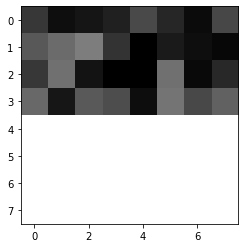

In [41]:
%matplotlib inline 
from matplotlib import pyplot as plt

for x,_ in data_loader:
    plt.imshow(x.numpy()[0][0], cmap='gray')
    break

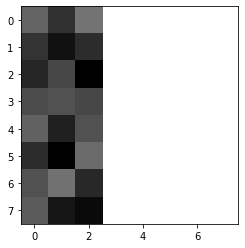

In [44]:

plt.imshow(data_set[700][0].view(8,8))



In [ ]:
# Generator:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()

        # Label should be embedded and changed to (128,1,8,8) in order to concatenate with noise of same input
        self.embed = nn.Embedding(2,8*8)

        # Noise of input dim (128,100) is changed to (128,511,8,8)
        self.changenoise = nn.Sequential(nn.Linear(100,511*64), nn.ReLU())

        self.model = nn.Sequential(nn.ConvTranspose2d(512,256,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(256,128,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(128,64,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(64,32,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(32,16,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(16,8,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.BatchNorm2d(8),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(8,1,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.Tanh())

    def forward(self,noise,label):
        label = self.embed(label)
        label = label.view(-1,1,8,8)
        noise = self.changenoise(noise)
        noise = noise.view(-1,511,8,8)
        input = torch.cat((noise,label),dim=1)
        image = self.model(input)
        return image

# Discriminator:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        # Label should be embedded and changed to (128,1,8,8) in order to concatenate with image of same input
        self.embed = nn.Embedding(2,8*8)

        self.model = nn.Sequential(nn.Conv2d(2,32,kernel_size=3,stride=2,bias=False),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),   # output - (128,32,4,4)
                                   nn.Conv2d(32,64,kernel_size=3,stride=2,bias=False),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),   # output - (128,64,2,2)
                                   nn.Flatten(),
                                   nn.Linear(64,1),
                                   nn.Sigmoid())

    def forward(self,image,label):
        label = self.embed(label)
        label = label.view(-1,1,8,8)
        input = torch.cat((image,label),dim=1)
        output = self.model(input)
        return output

generator = Generator()
discriminator = Discriminator()

In [ ]:
device = torch.device("cuda")
torch.cuda.empty_cache()

generator,discriminator = generator.to(device),discriminator.to(device)
print(generator)
print(discriminator)

Generator(
  (embed): Embedding(2, 64)
  (changenoise): Sequential(
    (0): Linear(in_features=100, out_features=32704, bias=True)
    (1): ReLU()
  )
  (model): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Co

In [45]:

n_epoch = 250
batch_size = 100
D_optimizer = optim.Adam(discriminator.parameters(), lr=0.002)
G_optimizer = optim.Adam(generator.parameters(), lr=0.002)
dloss = nn.BCELoss()
gloss = nn.BCELoss()

In [46]:
for epoch in range(n_epoch):
  
   for _,inputs in enumerate(data_loader):

    real_images,label = inputs
    real_images,label = real_images.to(device),label.to(device)

    noise = torch.randn(batch_size,100).to(device)
    fake_target = torch.zeros(batch_size,1).to(device)
    real_target = torch.ones(batch_size,1).to(device)

    D_optimizer.zero_grad()
    xx = discriminator(real_images,label)
    D_real_loss = dloss(xx, real_target)

    generated_image = generator(noise, fake_target.int())
    output = discriminator(generated_image, label)
    D_fake_loss = dloss(output, fake_target)

    # For discriminator:
    D_total_loss = (D_real_loss + D_fake_loss)/2
    D_total_loss = D_total_loss.to(torch.float32)
    D_total_loss.backward(retain_graph=True)
    D_optimizer.step()

    # For generator:
    G_optimizer.zero_grad()
    yy = discriminator(generated_image, label)
    G_loss = gloss(yy, real_target)
    G_loss.backward()
    G_optimizer.step()

    if epoch%10 == 0:
        print('D_loss:',D_total_loss,'G_loss:',G_loss)

D_loss: tensor(0.5077, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(1.7463, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss: tensor(0.5192, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(1.3783, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss: tensor(0.3610, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(1.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss: tensor(0.4672, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(1.1143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss: tensor(0.3774, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(1.4057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss: tensor(0.0323, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(5.0460, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss: tensor(0.0299, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(4.3804, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss

KeyboardInterrupt: ignored

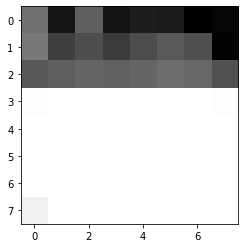

In [52]:
img=[]
generated_image = generated_image.to("cpu")
plt.imshow(generated_image[89].detach().view(8,8))



# For horizontal edge

TypeError: ignored

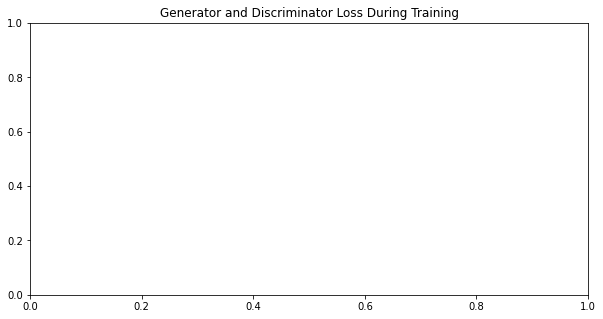

In [55]:

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss,label="G")
plt.plot(D_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()